In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'
old_stdout = sys.stdout

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, BatchNormalization
from keras import initializers, regularizers, optimizers, losses
#K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

from datetime import datetime
print('[INFO] Current time {0}'.format(str(datetime.now())))


# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

nvariables = (nlayers * 5) + 8

discr_pt_cut = 14.

reg_pt_scale = 100.

discr_loss_weight = 1.

add_noise = True

infile_muon = '/scratch/CMS/L1MuonTrigger/P2_9_2_3_patch1/SingleMuon_Toy_2GeV/histos_tba.13.npz'

infile_pileup = '/scratch/CMS/L1MuonTrigger/P2_9_2_3_patch1/SingleMuon_Toy_2GeV/histos_tbd.13.npz'


[INFO] Using numpy 1.14.5


Using TensorFlow backend.


[INFO] Using keras 2.2.0
[INFO] Using tensorflow 1.8.0
[INFO] Using sklearn 0.19.1
[INFO] Current time 2018-07-10 17:03:15.692037


In [2]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis]
      self.x_zone         = self.x_road[:, 1][:, np.newaxis]
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      # + Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        x_theta_tmp   = np.abs(self.x_theta) > theta_cuts
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        self.x_ring[x_ring_tmp] = 0  # ring 1,4 -> 0
        self.x_ring[~x_ring_tmp] = 1 # ring 2,3 -> 1
        x_fr_tmp      = self.x_fr.astype(np.int32)
        x_fr_tmp      = (x_fr_tmp == 0)
        self.x_fr[x_fr_tmp] = 0
        self.x_fr[~x_fr_tmp] = 1
      elif adjust_scale == 3:  # adjust by hand #2
        #theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts    = np.array((6., 6., 6., 6., 6., 10., 10., 10., 10., 8., 8., 8.), dtype=np.float32)
        x_theta_tmp   = np.abs(self.x_theta) > theta_cuts
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        self.x_ring[x_ring_tmp] = 0  # ring 1,4 -> 0
        self.x_ring[~x_ring_tmp] = 1 # ring 2,3 -> 1
        x_fr_tmp      = self.x_fr.astype(np.int32)
        x_fr_tmp      = (x_fr_tmp == 0)
        self.x_fr[x_fr_tmp] = 0
        self.x_fr[~x_fr_tmp] = 1
        s = [ 0.00528005,  0.01100854, -0.01955833, -0.01326062, -0.00839341,
              0.01209313, -0.02546741, -0.011541  , -0.00734255,  0.00393156,
             -0.02459449,  1.        ,  0.55500895,  0.50743203,  1.4219028 ,
              1.35162982,  0.93576706,  0.19965793,  0.29495697,  0.35250728,
              0.38013349,  0.50885451,  0.66930139,  1.        ,  0.81924683,
              0.47289819,  1.67281557,  1.1339659 ,  1.13266964,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,  1.        ,  1.        ]
        self.x_copy *= s
      
      # Remove outlier hits by checking hit thetas
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness = np.abs(self.x_straightness - 6.) / 6.  # scaled to [0,1]
      self.x_zone         = (self.x_zone - 0.) / 5.  # scaled to [0,1]
      self.x_theta_median = (self.x_theta_median - 3.) / 83.  # scaled to [0,1]
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [3]:
import tensorflow as tf
from keras import backend as K

# ______________________________________________________________________________
# New leaky relu
def NewLeakyReLU(x, alpha=0., max_value=None):
  return K.relu(x, alpha=alpha, max_value=max_value)

# ______________________________________________________________________________
# New tanh
def NewTanh(x):
  return K.tanh(x)
  #return 1.7159 * K.tanh(x * 2./3.)
  #return K.clip(x, -1., 1.)

# ______________________________________________________________________________
# Huber loss
def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

def masked_huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow

  mask_value = 100.
  mask = K.not_equal(y_true, mask_value)
  mask = K.cast(mask, K.floatx())
  xx *= mask
  xx /= K.mean(mask)
  return K.mean(xx, axis=-1)

#def masked_huber_loss(y_true, y_pred, delta=1.345):
#  mask_value = 100.
#  mask_alpha = 0.02
#  mask_target = 0.5 * reg_pt_scale
#  mask = K.equal(y_true, mask_value)
#  
#  #x = K.abs(y_true - y_pred)
#  x = tf.where(mask, mask_alpha * K.abs(mask_target - K.abs(y_pred)), K.abs(y_true - y_pred))
#  squared_loss = 0.5*K.square(x)
#  absolute_loss = delta * (x - 0.5*delta)
#  #xx = K.switch(x < delta, squared_loss, absolute_loss)
#  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
#  return K.mean(xx, axis=-1)


# ______________________________________________________________________________
# Binary crossentropy
def masked_binary_crossentropy(y_true, y_pred, from_logits=False):
  target, output = y_true, y_pred

  # transform back to logits
  if not from_logits:
    output = K.clip(output, K.epsilon(), 1 - K.epsilon())
    output = K.log(output / (1 - output))
  
  xx =  tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
  #xx =  tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=0.5)  # pos_weight < 1 decreases the false positive count

  mask_value = 100.
  mask = K.not_equal(y_true, mask_value)
  mask = K.cast(mask, K.floatx())
  xx *= mask
  xx /= K.mean(mask)
  return K.mean(xx, axis=-1)


# ______________________________________________________________________________
# Learning rate decay by epoch number
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
  if (epoch % 10) == 0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*0.95)
    print("lr changed to {}".format(lr*0.95))
  return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(lr_schedule)


# ______________________________________________________________________________
# Custom objects
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'masked_huber_loss': masked_huber_loss, 'masked_binary_crossentropy': masked_binary_crossentropy, 'NewLeakyReLU': NewLeakyReLU, 'NewTanh': NewTanh})

In [4]:
#### Load data ####

def muon_data():
  try:
    print('[INFO] Loading muon data ...')
    loaded = np.load(infile_muon)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
    print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile_muon))

  encoder = Encoder(the_variables, the_parameters, adjust_scale=3)
  x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  assert np.isfinite(x).all()

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.3)
  return x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test

# ______________________________________________________________________________
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = muon_data()

# Add output nodes
labels = np.where(np.abs(1.0/y_train) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
y_train = [y_train, labels.astype(np.float32)]

labels = np.where(np.abs(1.0/y_test) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
y_test = [y_test, labels.astype(np.float32)]

[INFO] Loading muon data ...
[INFO] Loaded the variables with shape (3643811, 76)
[INFO] Loaded the parameters with shape (3643811, 3)


/home/uf/jlow/jftest2/miniconda3/envs/tensorflow_conda/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/uf/jlow/jftest2/miniconda3/envs/tensorflow_conda/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


In [5]:
#### Load data (pileup) ####

def pileup_data():
  try:
    print('[INFO] Loading pileup data ...')
    loaded = np.load(infile_pileup)
    the_variables = loaded['variables']
    the_parameters = np.zeros((the_variables.shape[0], 3), dtype=np.float32)
    the_auxiliaries = loaded['aux']
    print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
    print('[INFO] Loaded the auxiliary info with shape {0}'.format(the_auxiliaries.shape))
  except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile_pileup))

  sel = the_auxiliaries[:,2] > discr_pt_cut
  the_variables = the_variables[~sel]
  the_parameters = the_parameters[~sel]
  the_auxiliaries = the_auxiliaries[~sel]

  encoder = Encoder(the_variables, the_parameters, adjust_scale=3)
  x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  aux = the_auxiliaries  # jobid, ievt, highest_part_pt, highest_track_pt
  assert np.isfinite(x).all()

  # Split dataset in training and testing
  split = the_auxiliaries[:,0] < 50.
  x_train, x_test, aux_train, aux_test = x[~split], x[split], aux[~split], aux[split]
  return x_train, x_test, aux_train, aux_test

# ______________________________________________________________________________
x_adv_train, x_adv_test, aux_adv_train, aux_adv_test = pileup_data()

[INFO] Loading pileup data ...
[INFO] Loaded the variables with shape (171550, 76)
[INFO] Loaded the auxiliary info with shape (171550, 4)


/home/uf/jlow/jftest2/miniconda3/envs/tensorflow_conda/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


In [6]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
#     https://keras.io/getting-started/functional-api-guide/#getting-started-with-the-keras-functional-api

def create_model():
  inputs = Input(shape=(nvariables,), dtype='float32')

  x = Dense(64, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(inputs)
  #x = Dropout(0.2)(x)
  x = Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(x)
  #x = Dropout(0.2)(x)
  x = Dense(16, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000))(x)
  #x = Dropout(0.2)(x)

  regr = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='regr')(x)
  discr = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', name='discr')(x)

  # This creates a model that includes
  # the Input layer, three Dense layers and the Output layer
  model = Model(inputs=inputs, outputs=[regr, discr])

  # Set loss and optimizers
  #binary_crossentropy = losses.binary_crossentropy
  #mean_squared_error = losses.mean_squared_error

  adam = optimizers.Adam(lr=0.00113)
  #adam = optimizers.Adam(lr=0.001)  # default
  #adam = optimizers.Adam(lr=0.01)
  #adam = optimizers.Adam(lr=0.001, amsgrad=True)

  # Compile
  model.compile(optimizer=adam,
    loss={'regr': masked_huber_loss, 'discr': masked_binary_crossentropy},
    loss_weights={'regr': 1.0, 'discr': discr_loss_weight},
    #metrics={'regr': ['acc', 'mse', 'mae'], 'discr': ['acc',]}
    )
  return model

def create_model_sequential():
  model = Sequential()
  model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
  #model.add(Dropout(0.2))
  model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
  #model.add(Dropout(0.2))
  model.add(Dense(16, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
  #model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))
  
  adam = optimizers.Adam(lr=0.001)
  model.compile(loss=huber_loss, optimizer=adam, metrics=['acc'])
  return model

def save_model(model):
  # Store model to file
  model.summary()
  model.save('model.h5')
  model.save_weights('model_weights.h5')

  # Store model to json
  import json
  with open('model.json', 'w') as outfile:
    outfile.write(model.to_json())
  return

# ______________________________________________________________________________
model = create_model()

In [7]:
#### Training Functions ####

# from https://github.com/keras-team/keras/blob/master/keras/utils/generic_utils.py
def slice_arrays(arrays, start=None, stop=None):
    """Slices an array or list of arrays.
    This takes an array-like, or a list of
    array-likes, and outputs:
        - arrays[start:stop] if `arrays` is an array-like
        - [x[start:stop] for x in arrays] if `arrays` is a list
    Can also work on list/array of indices: `_slice_arrays(x, indices)`
    # Arguments
        arrays: Single array or list of arrays.
        start: can be an integer index (start index)
            or a list/array of indices
        stop: integer (stop index); should be None if
            `start` was a list.
    # Returns
        A slice of the array(s).
    """
    if arrays is None:
        return [None]
    elif isinstance(arrays, list):
        if hasattr(start, '__len__'):
            # hdf5 datasets only support list objects as indices
            if hasattr(start, 'shape'):
                start = start.tolist()
            return [None if x is None else x[start] for x in arrays]
        else:
            return [None if x is None else x[start:stop] for x in arrays]
    else:
        if hasattr(start, '__len__'):
            if hasattr(start, 'shape'):
                start = start.tolist()
            return arrays[start]
        elif hasattr(start, '__getitem__'):
            return arrays[start:stop]
        else:
            return [None]


def merge_arrays(arrays, arrays_to_add):
    if isinstance(arrays, list):
        return [None if x is None else np.concatenate((x,y)) for (x,y) in zip(arrays, arrays_to_add)]
    else:
        return [None]

# from https://github.com/keras-team/keras/blob/master/keras/engine/training_utils.py
def make_batches(size, batch_size):
    """Returns a list of batch indices (tuples of indices).
    # Arguments
        size: Integer, total size of the data to slice into batches.
        batch_size: Integer, batch size.
    # Returns
        A list of tuples of array indices.
    """
    num_batches = (size + batch_size - 1) // batch_size  # round up
    return [(i * batch_size, min(size, (i + 1) * batch_size))
            for i in range(num_batches)]

# ______________________________________________________________________________
# from https://github.com/keras-team/keras/blob/2.0.5/keras/engine/training.py

import copy
from keras import callbacks as cbks
from keras.utils.generic_utils import Progbar

def train(model, x, y, x_adv, aux_adv, batch_size=None, epochs=1, verbose=1, callbacks=None,
          validation_split=0., shuffle=True, class_weight=None, sample_weight=None):
  
  # Validate user data.
  x, y, sample_weights = model._standardize_user_data(
    x, y,
    sample_weight=sample_weight,
    class_weight=class_weight,
    batch_size=batch_size)
  
  y = [y[0] * reg_pt_scale, y[1]]
  
  # Prepare input arrays
  if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
    ins = x + y + sample_weights + [1.]
  else:
    ins = x + y + sample_weights

  #print('[INFO] ins shapes: {0}'.format([xx.shape for xx in ins]))
  
  # Prepare validation data.
  do_validation = False
  if validation_split and 0. < validation_split < 1.:
    do_validation = True
    if hasattr(x[0], 'shape'):
      split_at = int(x[0].shape[0] * (1. - validation_split))
    else:
      split_at = int(len(x[0]) * (1. - validation_split))
    x, val_x = (slice_arrays(x, 0, split_at), slice_arrays(x, split_at))
    y, val_y = (slice_arrays(y, 0, split_at), slice_arrays(y, split_at))
    sample_weights, val_sample_weights = (slice_arrays(sample_weights, 0, split_at), slice_arrays(sample_weights, split_at))
    if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
      val_ins = val_x + val_y + val_sample_weights + [0.]
    else:
      val_ins = val_x + val_y + val_sample_weights
  else:
    val_ins = []

  # logic from `_fit_loop()`
  num_train_samples = x[0].shape[0]
  index_array = np.arange(num_train_samples)
  num_test_samples = val_x[0].shape[0]
  val_index_array = np.arange(num_test_samples)
  
  # Callbacks
  out_labels = model.metrics_names
  if do_validation:
    callback_metrics = copy.copy(out_labels) + ['val_' + n for n in out_labels]
  else:
    callback_metrics = copy.copy(out_labels)

  model.history = cbks.History()
  callbacks = [cbks.BaseLogger()] + (callbacks or []) + [model.history]
  if verbose:
    callbacks += [cbks.ProgbarLogger()]
  callbacks = cbks.CallbackList(callbacks)
  callback_model = model
  callbacks.set_model(callback_model)
  callbacks.set_params({
      'batch_size': batch_size,
      'epochs': epochs,
      'samples': num_train_samples,
      'verbose': verbose,
      'do_validation': do_validation,
      'metrics': callback_metrics or [],
  })
  callbacks.on_train_begin()
  callback_model.stop_training = False
  for cbk in callbacks:
      cbk.validation_data = val_ins
  
  
  # Loop over epochs
  for epoch in xrange(epochs):
    epoch_logs = {}
    callbacks.on_epoch_begin(epoch)
    
    if shuffle:
      np.random.shuffle(index_array)
      #np.random.shuffle(val_index_array)
    
    batches = make_batches(num_train_samples, batch_size)
    
    # Loop over batches
    for batch_index, (batch_start, batch_end) in enumerate(batches):
      batch_ids = index_array[batch_start:batch_end]
      if ins and isinstance(ins[-1], float):
        # Do not slice the training phase flag.
        ins_batch = slice_arrays(ins[:-1], batch_ids) + [ins[-1]]
        assert isinstance(ins_batch, list) and len(ins_batch) == 1 + 2 + 2 + 1
      else:
        ins_batch = slice_arrays(ins, batch_ids)
        assert isinstance(ins_batch, list) and len(ins_batch) == 1 + 2 + 2
      
      # Add noise (pileup)
      if add_noise:
        #noise = x_adv[np.random.randint(0, x_adv.shape[0], ins_batch[0].shape[0])]
        #noise_reg = np.zeros_like(ins_batch[1]) + 100.  # mask_value is set to 100
        #noise_discr = np.zeros_like(ins_batch[2])
        #noise_reg_w = np.ones_like(ins_batch[3])
        #noise_discr_w = np.ones_like(ins_batch[3])
        n = np.sum(np.equal(ins_batch[2],1.))
        noise = x_adv[np.random.randint(0, x_adv.shape[0], n)]
        noise_reg = np.zeros((n,1)) + 100.  # mask_value is set to 100
        noise_discr = np.zeros((n,1))
        noise_reg_w = np.ones((n,))
        noise_discr_w = np.ones((n,))
        ins_noise = [noise, noise_reg, noise_discr, noise_reg_w, noise_discr_w]
        if ins and isinstance(ins[-1], float):
          ins_batch = merge_arrays(ins_batch[:-1], ins_noise) + [ins_batch[-1]]
        else:
          ins_batch = merge_arrays(ins_batch, ins_noise)
      
      batch_logs = {}
      batch_logs['batch'] = batch_index
      batch_logs['size'] = len(batch_ids)
      callbacks.on_batch_begin(batch_index, batch_logs)
      
      # Magic
      model._make_train_function()
      f = model.train_function
      outs = f(ins_batch)
      
      if not isinstance(outs, list):
        outs = [outs]
      for l, o in zip(out_labels, outs):
        batch_logs[l] = o
      
      callbacks.on_batch_end(batch_index, batch_logs)
      if callback_model.stop_training:
        break
      
      if batch_index == len(batches) - 1:  # Last batch.
        if do_validation:
          # logic from `_test_loop()`
          val_batches = make_batches(num_test_samples, batch_size)
          val_outs = []
          if verbose == 1:
            progbar = Progbar(target=num_test_samples)
          
          for val_batch_index, (val_batch_start, val_batch_end) in enumerate(val_batches):
            val_batch_ids = val_index_array[val_batch_start:val_batch_end]
            if isinstance(val_ins[-1], float):
              # Do not slice the training phase flag.
              val_ins_batch = slice_arrays(val_ins[:-1], val_batch_ids) + [val_ins[-1]]
            else:
              val_ins_batch = slice_arrays(val_ins, val_batch_ids)
            
            # Magic
            model._make_test_function()
            val_f = model.test_function
            val_batch_outs = val_f(val_ins_batch)
            
            if isinstance(val_batch_outs, list):
              if val_batch_index == 0:
                for i, val_batch_out in enumerate(val_batch_outs):
                  val_outs.append(0.)
              for i, val_batch_out in enumerate(val_batch_outs):
                val_outs[i] += val_batch_out * len(val_batch_ids)
            else:
              if val_batch_index == 0:
                val_outs.append(0.)
              val_outs[0] += val_batch_outs * len(val_batch_ids)
            
            if verbose == 1:
              progbar.update(val_batch_end)
            
          if not isinstance(val_outs, list):
            val_outs = [val_outs]
          # Same labels assumed.
          for l, o in zip(out_labels, val_outs):
            o /= num_test_samples
            epoch_logs['val_' + l] = o
            
    callbacks.on_epoch_end(epoch, epoch_logs)
    if callback_model.stop_training:
      break

  callbacks.on_train_end()
  return model.history

# ______________________________________________________________________________
def predict(model, x):
  outs = model.predict(x)
  outs[0] /= reg_pt_scale
  return outs

In [8]:
#### Training ####

print('[INFO] Begin training ...')
assert keras.backend.backend() == 'tensorflow'

start_time = time.time()
sys.stdout = open('keras_output_1.txt', 'w')
#history = model.fit(x_train, y_train, epochs=20, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, epochs=200, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=0)
history = train(model, x_train, y_train, x_adv_train, aux_adv_train, epochs=10, validation_split=0.1, batch_size=128, verbose=1)
#history = train(model, x_train, y_train, x_adv_train, aux_adv_train, epochs=300, validation_split=0.1, batch_size=128, callbacks=[lr_decay], verbose=1)
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

save_model(model)
print('[INFO] Done training.')
print('[INFO] Model is saved as model.h5, model.json and model_weights.h5')

[INFO] Begin training ...
[INFO] Time elapsed: 933.183779955 sec
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4416        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         dense_2[0][0]                    
____________________________________________

1093144/1093144 [==============================] - 2s 2us/step
[INFO] loss and metrics: [30.1234117574252, 30.09072832870927, 0.032683441041969394]


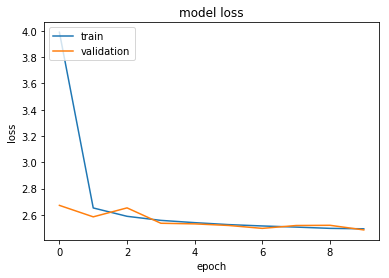

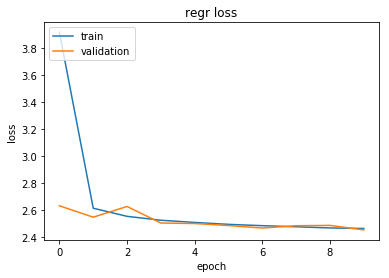

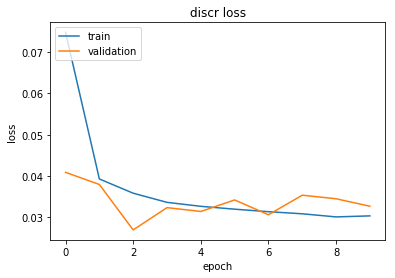

In [9]:
#### Evaluation ####

#loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
print('[INFO] loss and metrics: {0}'.format(loss_and_metrics))

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['regr_loss'])
plt.plot(history.history['val_regr_loss'])
plt.title('regr loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['discr_loss'])
plt.plot(history.history['val_discr_loss'])
plt.title('discr loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Mean Squared Error
#plt.plot(history.history['regr_mean_squared_error'])
#plt.plot(history.history['val_regr_mean_squared_error'])
#plt.title('regr mse')
#plt.ylabel('mse')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

## Mean Absolute Error
#plt.plot(history.history['regr_mean_absolute_error'])
#plt.plot(history.history['val_regr_mean_absolute_error'])
#plt.title('regr mae')
#plt.ylabel('mae')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

## Accuracy
#plt.plot(history.history['discr_acc'])
#plt.plot(history.history['val_discr_acc'])
#plt.title('discr accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()


In [10]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(72/4, 4, figsize=(4*4,4*72/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*5):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid,0]

    ymin, ymax = -0.6, 0.6
    if i < (nlayers*3):
      xmin, xmax = -1.5, 1.5
    elif i < (nlayers*5):
      xmin, xmax = -1.5, 1.5
    elif i < 68:
      xmin, xmax = -1.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [11]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  #print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(72/4, 4, figsize=(4*4,4*72/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 6) + 4)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*5):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < 14.)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = y_train[0][valid].copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        if lay == 0 or lay == 1:  # ME1/1 or ME1/2
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((np.abs(x_i),np.abs(y_i))))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        else:
          coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay == 0 or lay == 1:  # ME1/1 or ME1/2
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        else:
          coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ')

In [12]:
if False:
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    #xx = K.switch(x < delta, squared_loss, absolute_loss)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    #return K.mean(xx, axis=-1)
    return xx


  a = y_test[0][:nentries_test].copy()
  b = y_test_meas[0].copy()

  tmp = np.abs(1.0/a) > 20.
  a = a[tmp]
  b = b[tmp]

  #reg_pt_scale = 14.
  #a *= reg_pt_scale
  #b *= reg_pt_scale

  c = huber_loss(a, b)
  sess = tf.InteractiveSession()
  d = c.eval()
  #sess.close()
  e = (a-b).reshape(-1)
  f = d.reshape(-1)

  print len(a), len(b), a, b
  print e, f
  print np.min(f), np.max(f), np.median(f)
  print 0.5 * np.square(e), 1.345 * e
  print len(e), np.equal(0.5 * np.square(e), f).sum()
  print np.std(e), np.median(np.abs(e))
  
  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(e, bins=50, range=[-10,10])

  #fig, ax = plt.subplots()
  #ax.set_yscale('log')
  #_ = ax.hist(0.5 * np.square(e), bins=50, range=[0,10])

  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(f, bins=50, range=[0,10])

In [13]:
if False:
  a = y_test[0][:nentries_test].copy()
  b = y_test_meas[0].copy()

  tmp = np.abs(1.0/a) > 20.
  a = a[tmp]
  b = b[tmp]

  reg_pt_scale = 14.
  a *= reg_pt_scale
  b *= reg_pt_scale

  c = huber_loss(a, b)
  sess = tf.InteractiveSession()
  d = c.eval()
  #sess.close()
  e = (a-b).reshape(-1)
  f = d.reshape(-1)

  print len(a), len(b), a, b
  print e, f
  print np.min(f), np.max(f), np.median(f)

  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(e, bins=50, range=[-10,10])

  #fig, ax = plt.subplots()
  #ax.set_yscale('log')
  #_ = ax.hist(0.5 * np.square(e), bins=50, range=[0,10])

  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(f, bins=50, range=[0,10])

In [14]:
if False:
  def binary_crossentropy(y_true, y_pred, from_logits=False):
    target, output = tf.convert_to_tensor(y_true, np.float32), tf.convert_to_tensor(y_pred, np.float32)

    # transform back to logits
    if not from_logits:
      output = K.clip(output, K.epsilon(), 1 - K.epsilon())
      output = K.log(output / (1 - output))

    xx =  tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    #xx =  tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=0.5)  # pos_weight < 1 decreases the false positive count
    #return K.mean(xx, axis=-1)
    return xx


  a1 = y_test[1][:nentries_test].copy()
  a2 = y_adv_test[1].copy()

  b1 = y_test_meas[1].copy()
  b2 = y_adv_test_meas[1].copy()

  tmp = (a1 != 100.)
  a1 = a1[tmp]
  b1 = b1[tmp]

  a2 = a2[:,0]
  b2 = b2[:,0]
  tmp = np.random.randint(0, len(a2), len(a1))
  a2 = a2[tmp]
  b2 = b2[tmp]

  a = np.concatenate((a1, a2))
  b = np.concatenate((b1, b2))

  c = binary_crossentropy(a, b)
  #sess = tf.InteractiveSession()
  d = c.eval()
  #sess.close()
  e = (a-b).reshape(-1)
  f = d.reshape(-1)

  print len(a1), len(a2), len(b1), len(b2), a1, a2, b1, b2
  print len(a), len(b), a, b
  print np.min(f), np.max(f), np.median(f)

  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(e, bins=50, range=[-10,10])

  fig, ax = plt.subplots()
  ax.set_yscale('log')
  _ = ax.hist(f, bins=50, range=[0,10])

In [15]:
def read_h5py():
  import h5py

  f = h5py.File(model_weights_file)
  print f.keys()

  keys = [u'dense_1', u'dense_2', u'dense_3', u'regr', u'discr']
  for k in keys:
    try:
      w = f[k][k]['kernel:0'].value
      b = f[k][k]['bias:0'].value
      print k, w.shape, b.shape, np.min(np.abs(w)), np.max(np.abs(w))
      
      #FIXME
      if k == 'dense_1':
        a = np.sum(w*w, axis=0)
        b = np.sort(a)/np.sum(a)
        print "..", a, b
    except:
      pass

if False:
  read_h5py()

In [16]:
from datetime import datetime
print('[INFO] Current time {0}'.format(str(datetime.now())))

[INFO] Current time 2018-07-10 17:19:12.655900
